

==================== VISUALIZING FOLD 0 (Thresh: 0.7) ====================


C:\Users\lytten\AppData\Local\Temp\ipykernel_9436\1662906476.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=C

Test Patients in this fold: ['D2-001' 'D2-048' 'D2-027' 'D2-060' 'D2-019' 'D2-022' 'D2-018' 'D2-010']

--- Patient D2-001 ---


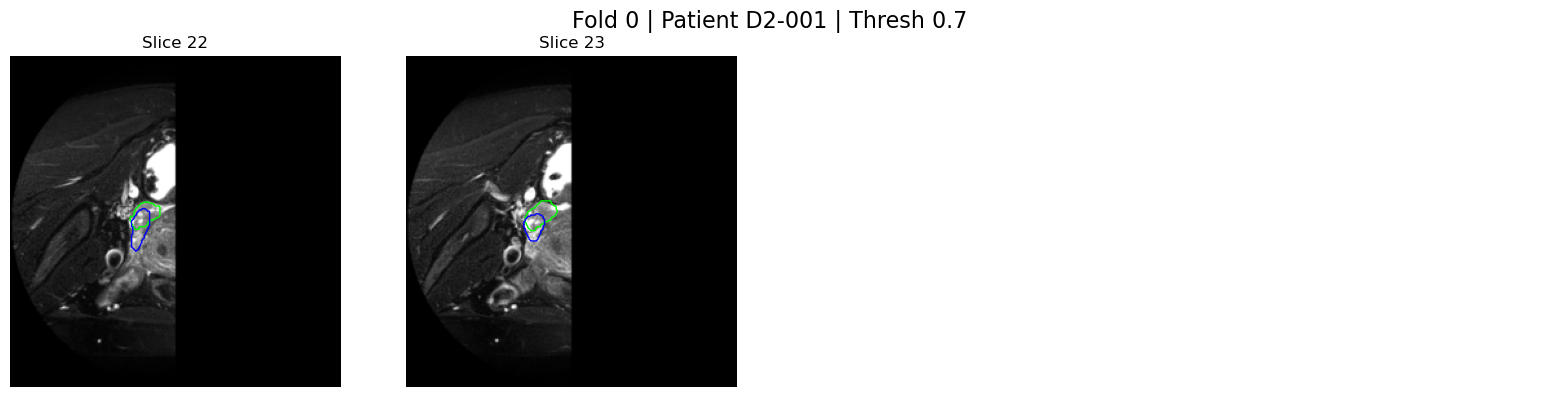


--- Patient D2-048 ---


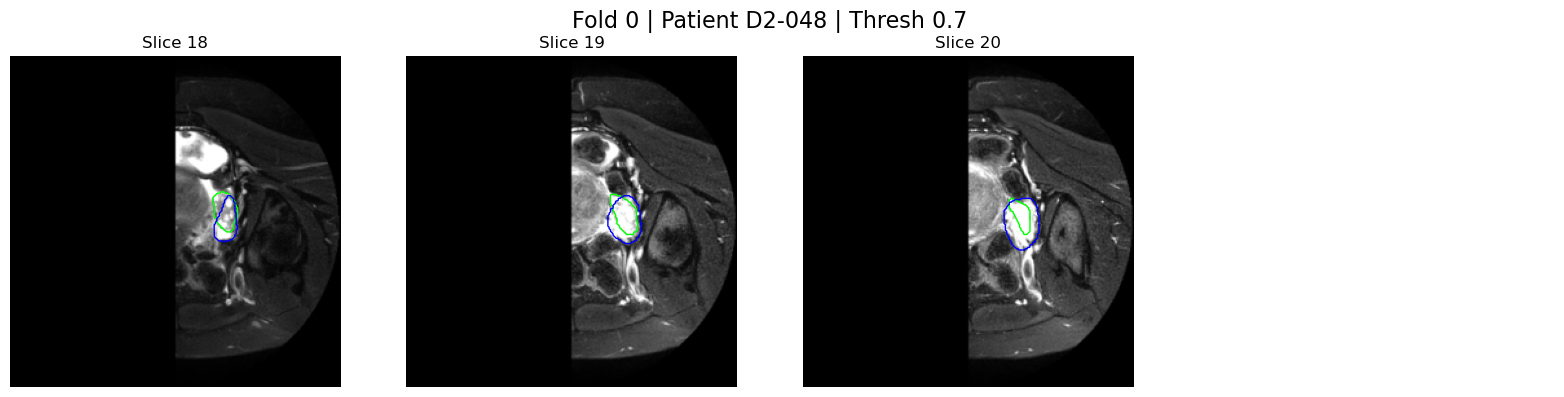


--- Patient D2-027 ---


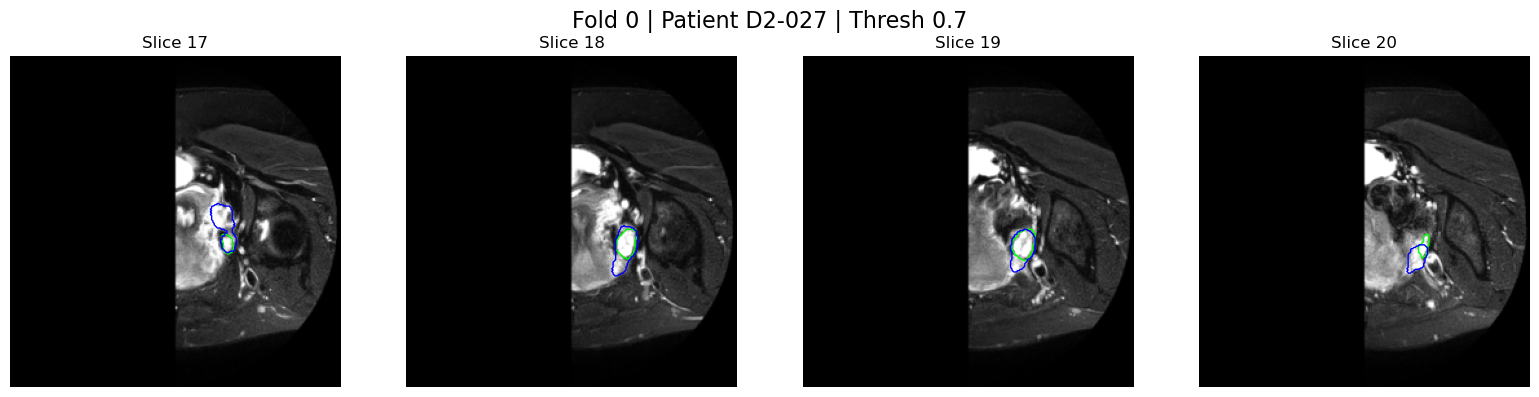


--- Patient D2-060 ---


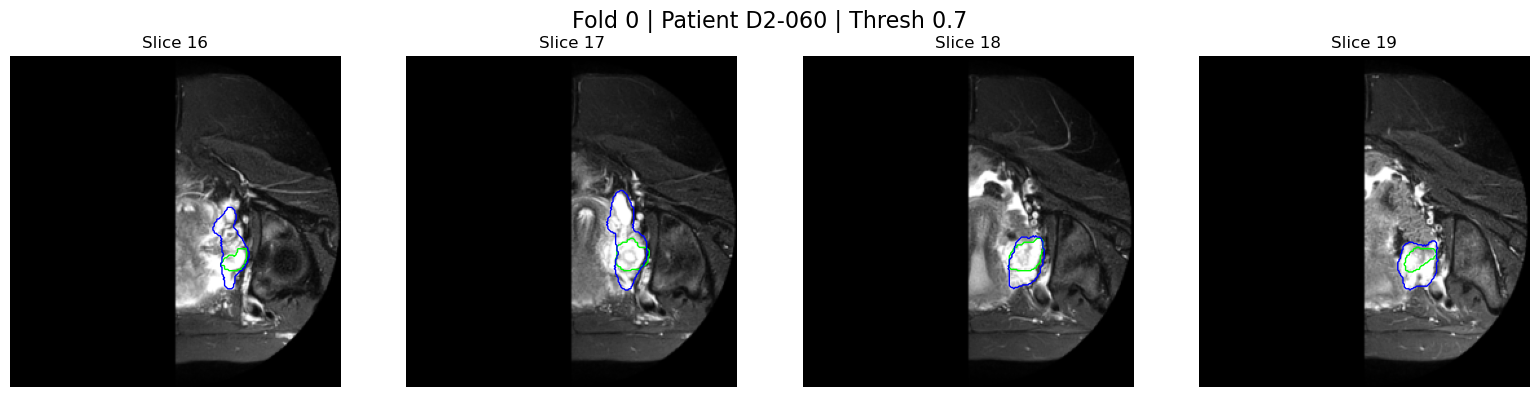


--- Patient D2-019 ---


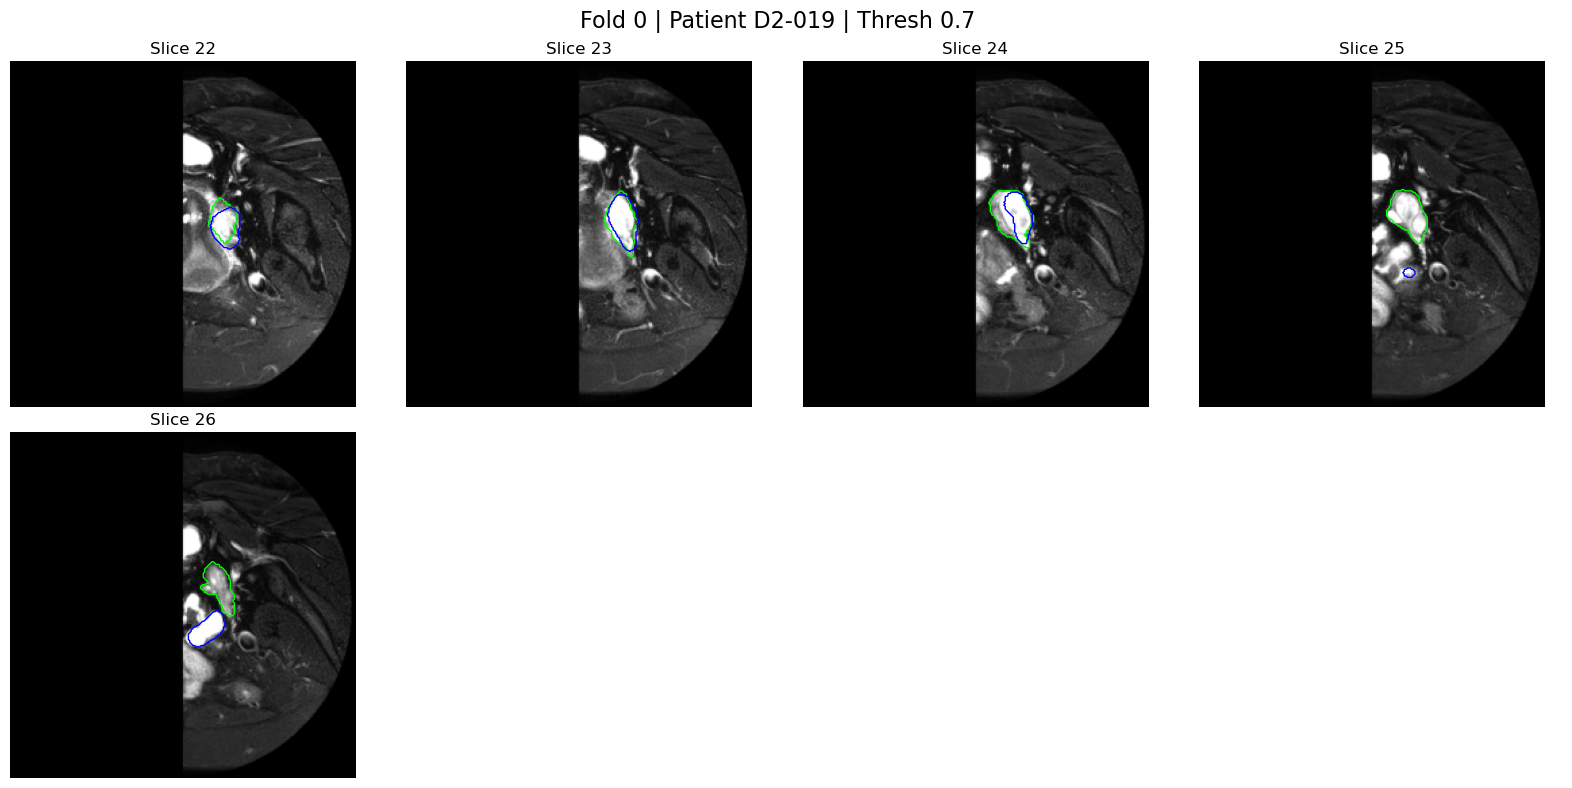


--- Patient D2-022 ---


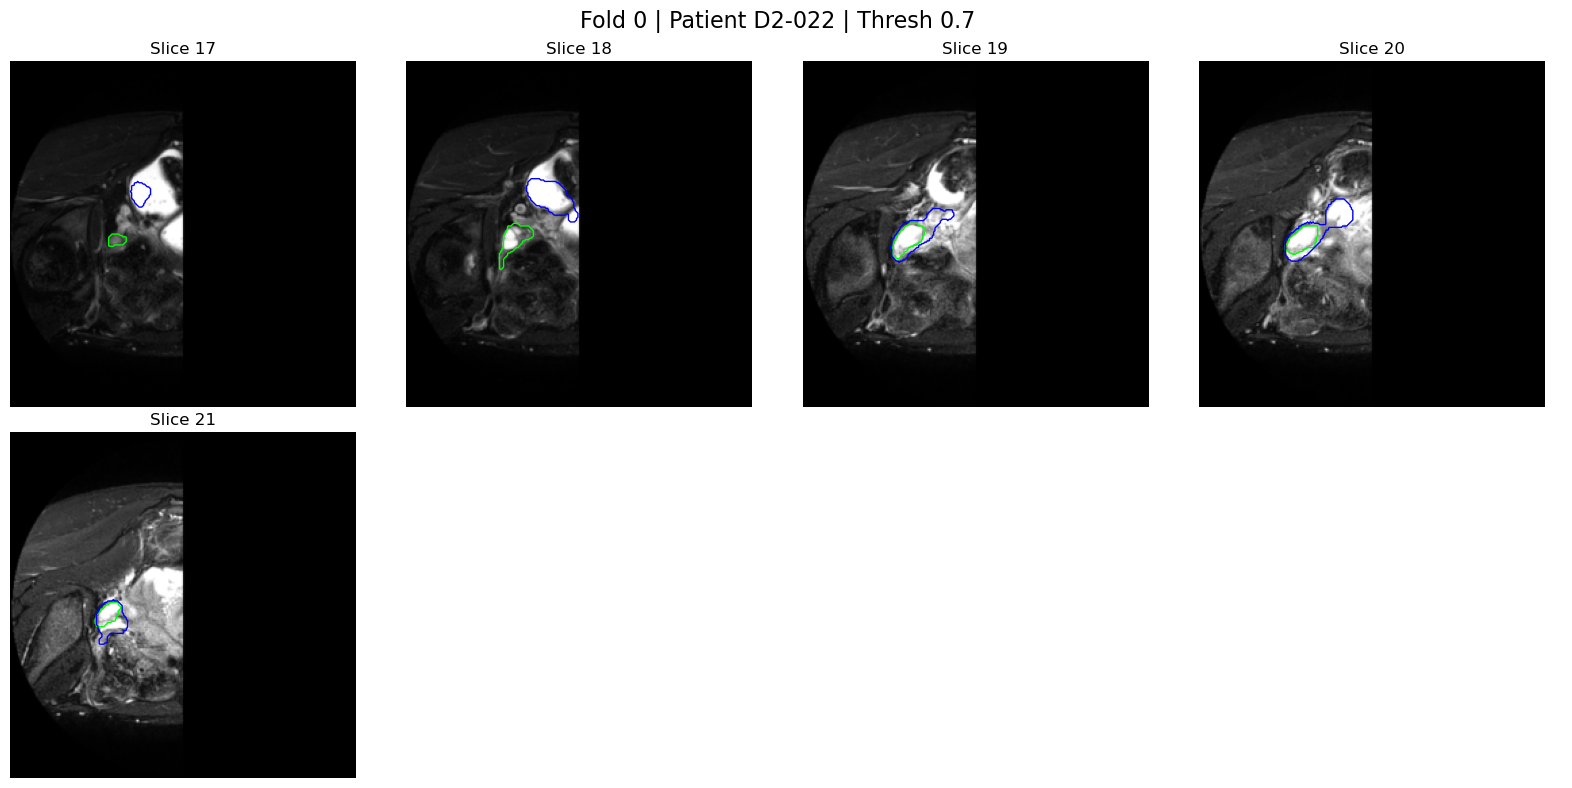


--- Patient D2-018 ---


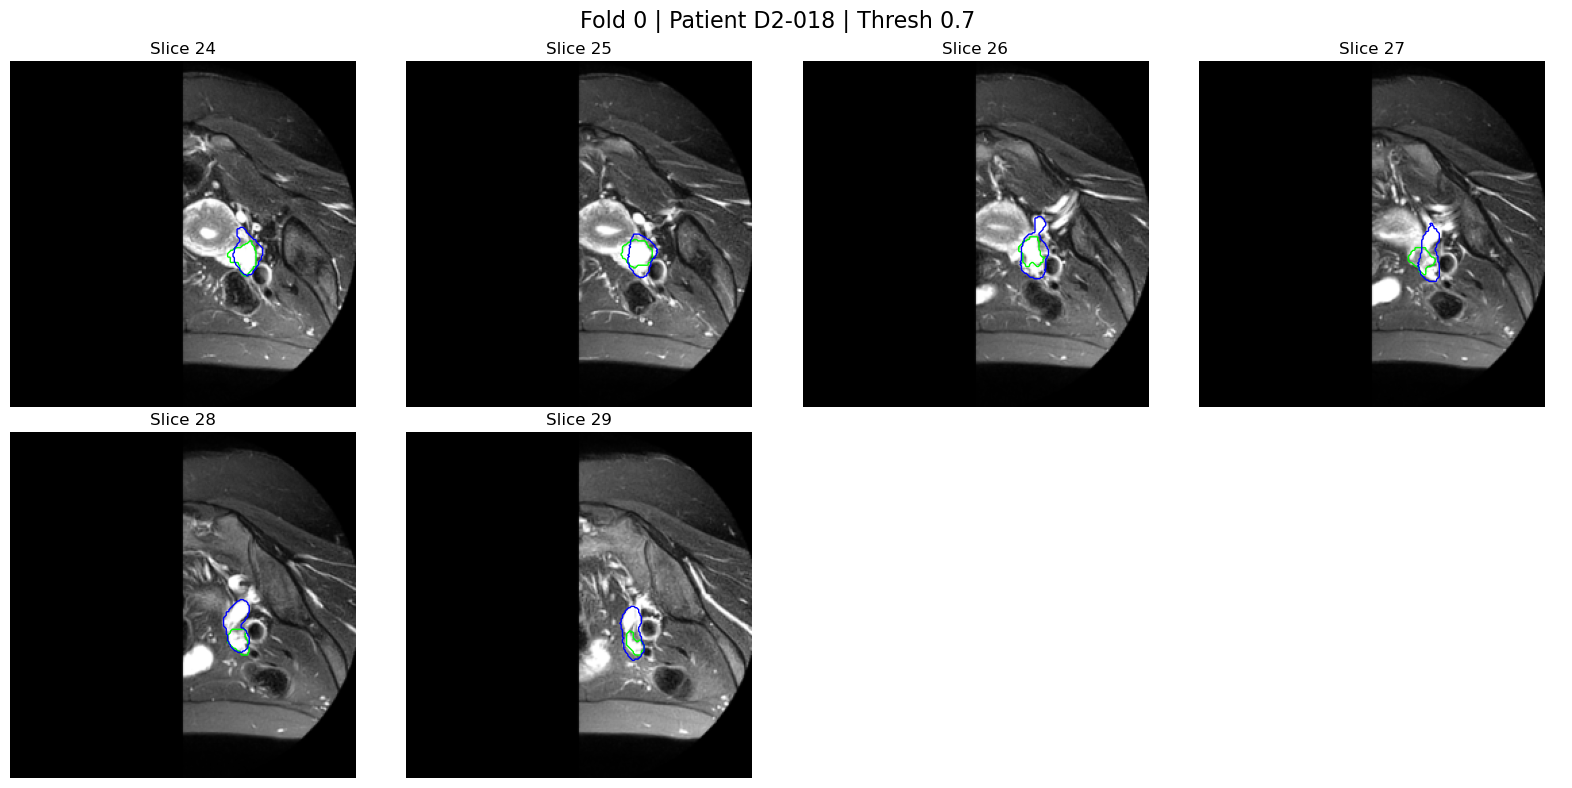


--- Patient D2-010 ---


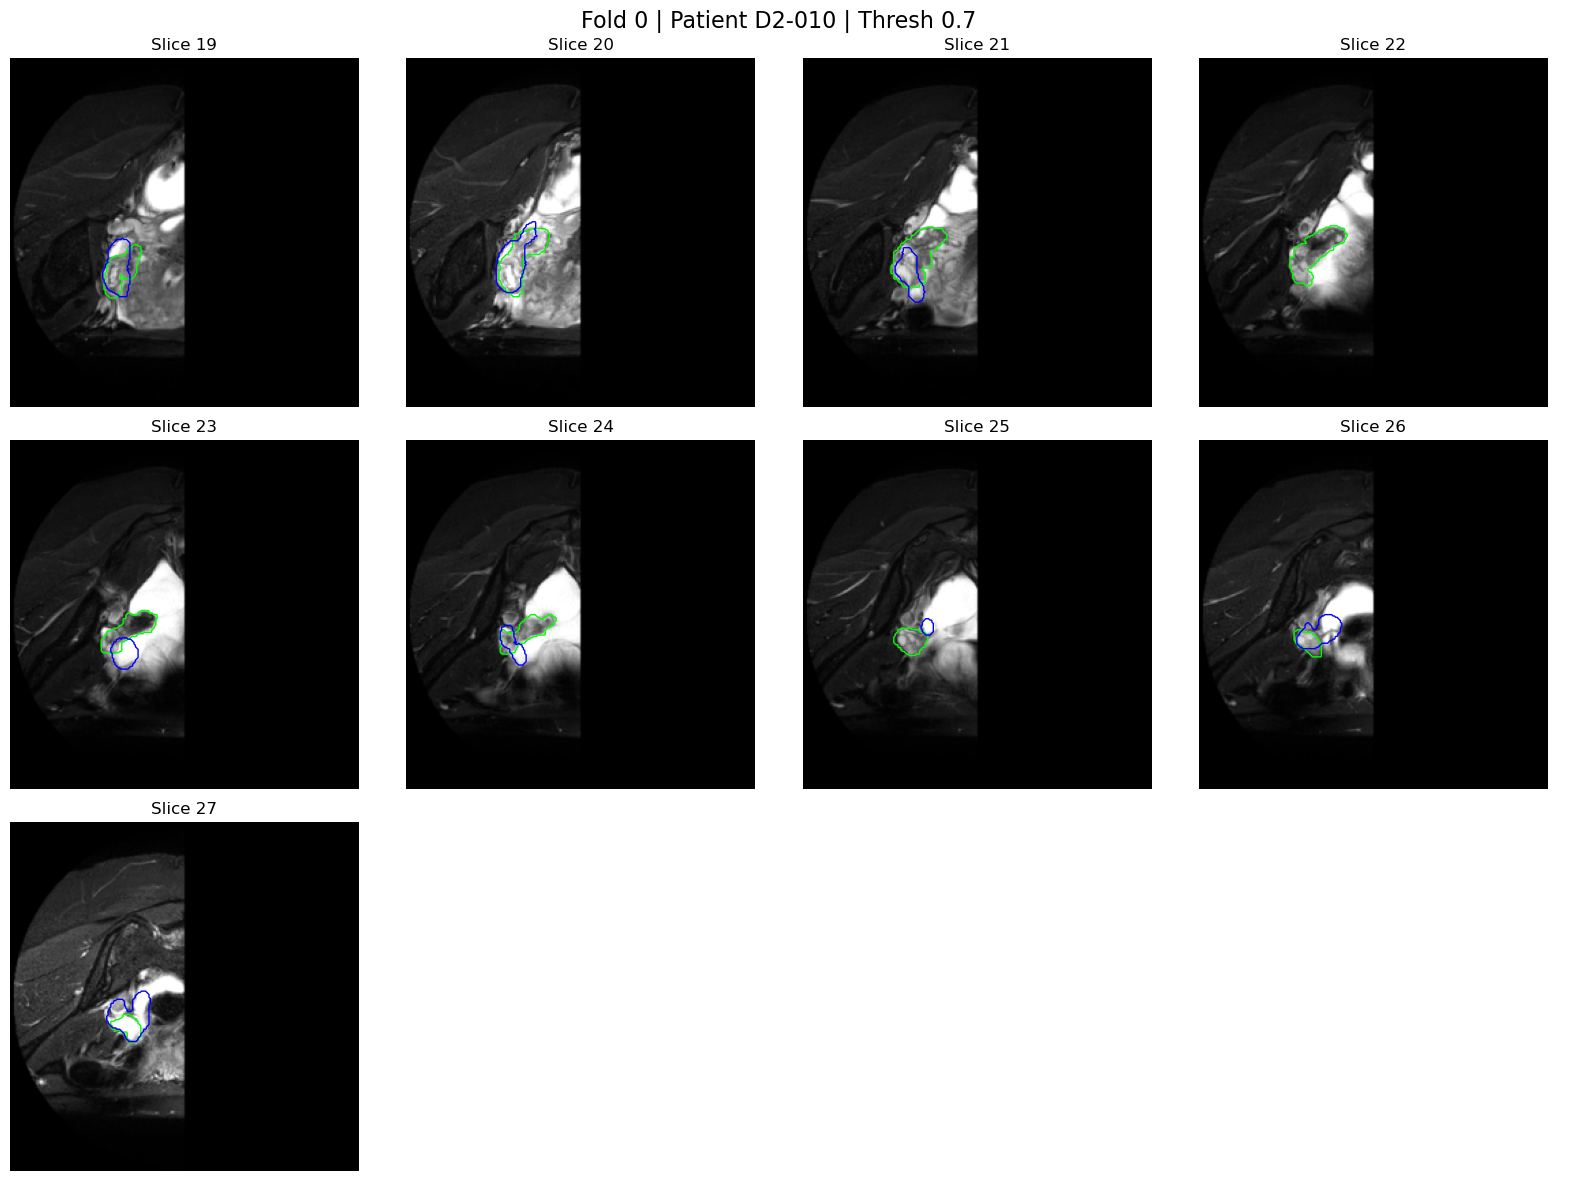



==================== VISUALIZING FOLD 2 (Thresh: 0.6) ====================
Test Patients in this fold: ['D2-051' 'D2-014' 'D2-028' 'D2-073' 'D2-058' 'D2-021' 'D2-025']

--- Patient D2-051 ---


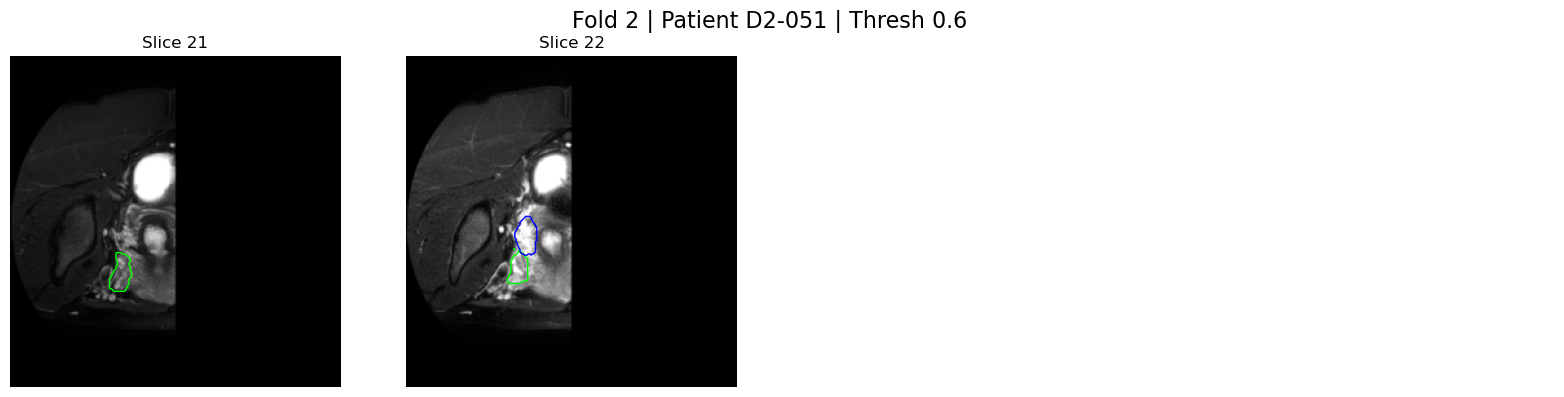


--- Patient D2-014 ---


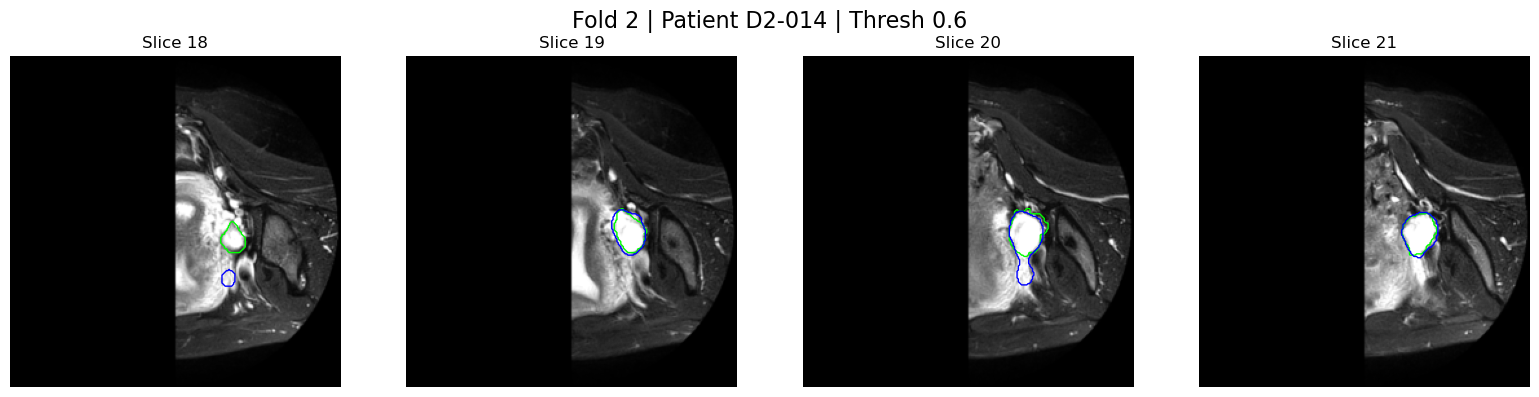


--- Patient D2-028 ---


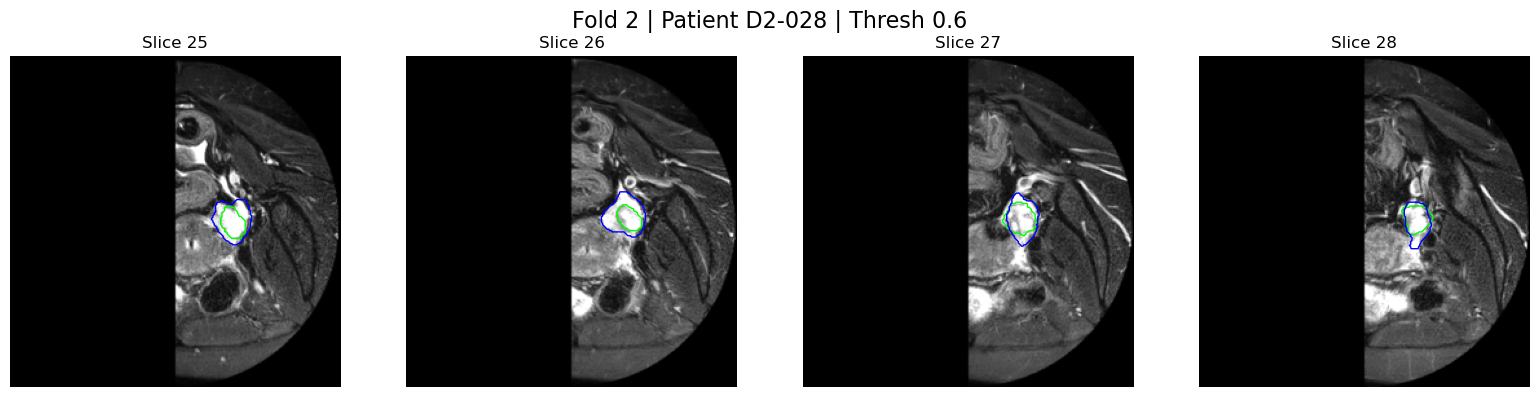


--- Patient D2-073 ---


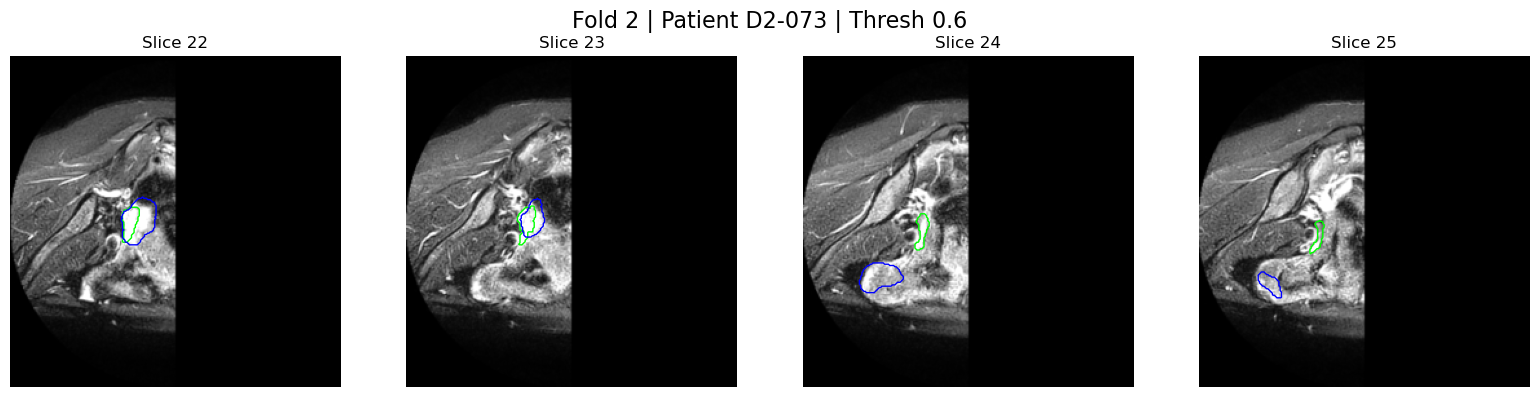


--- Patient D2-058 ---


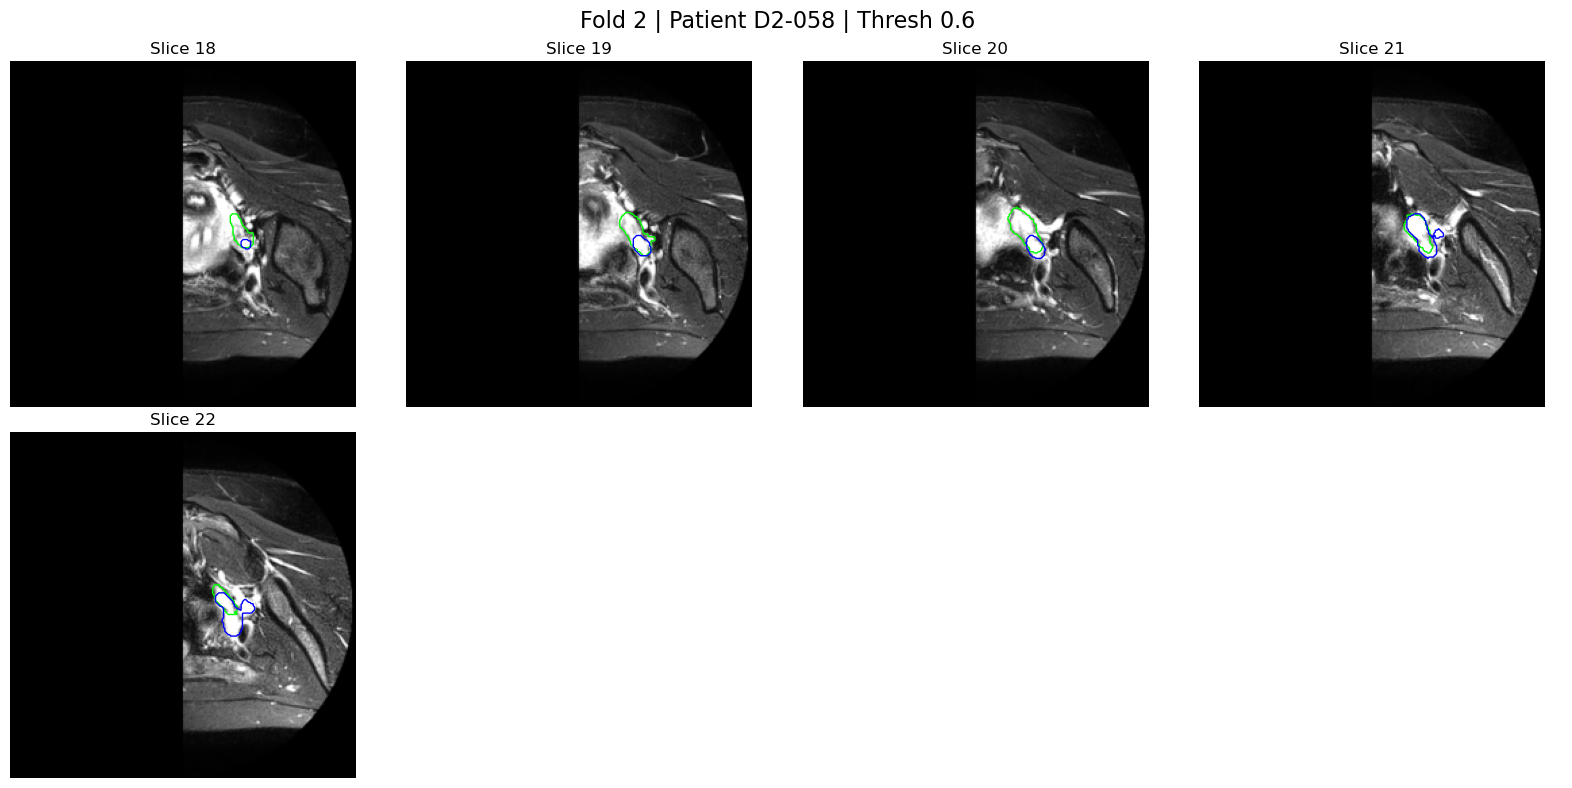


--- Patient D2-021 ---


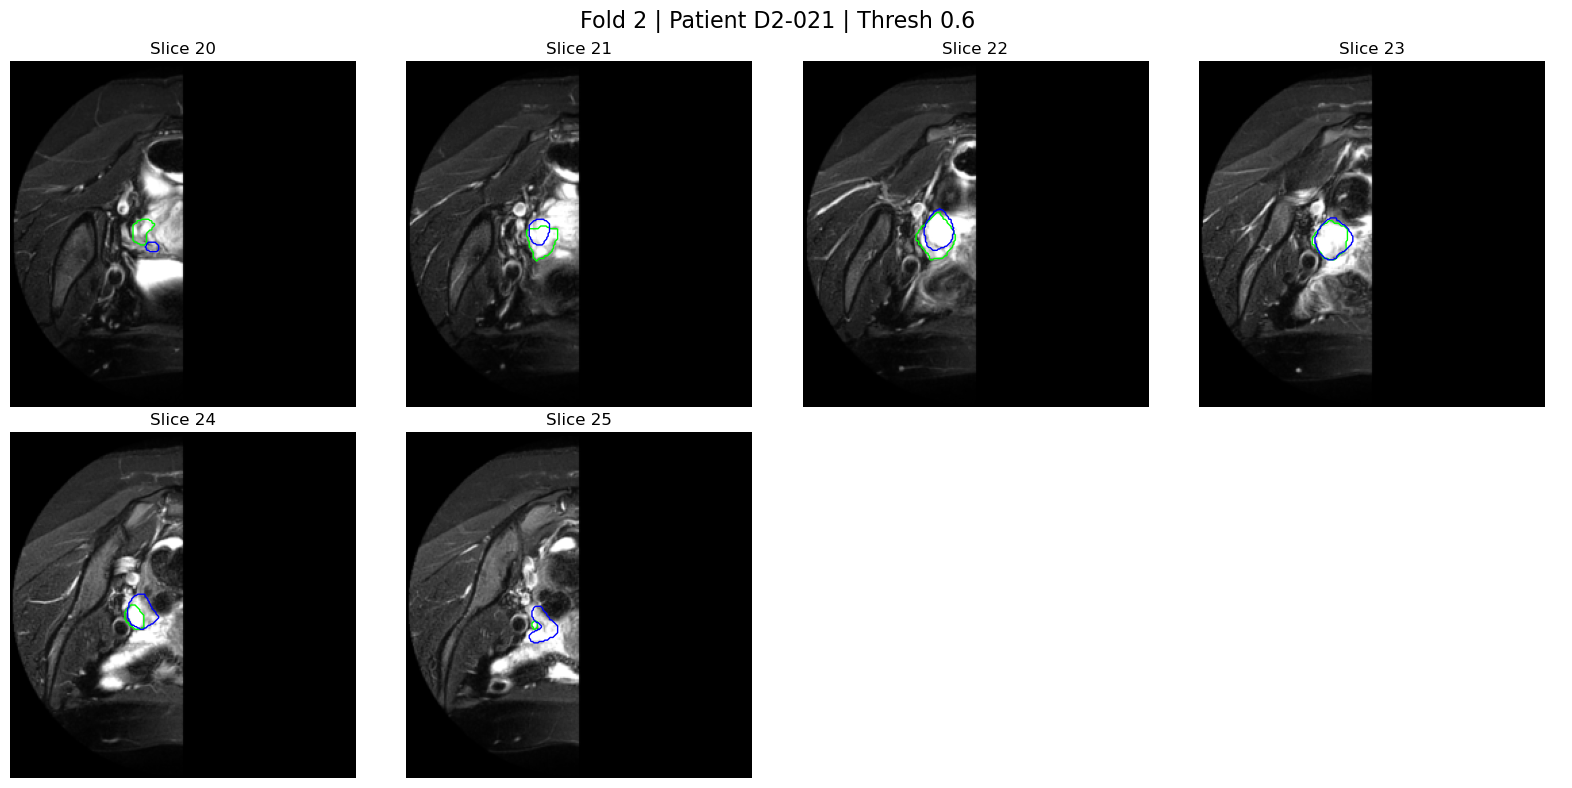


--- Patient D2-025 ---


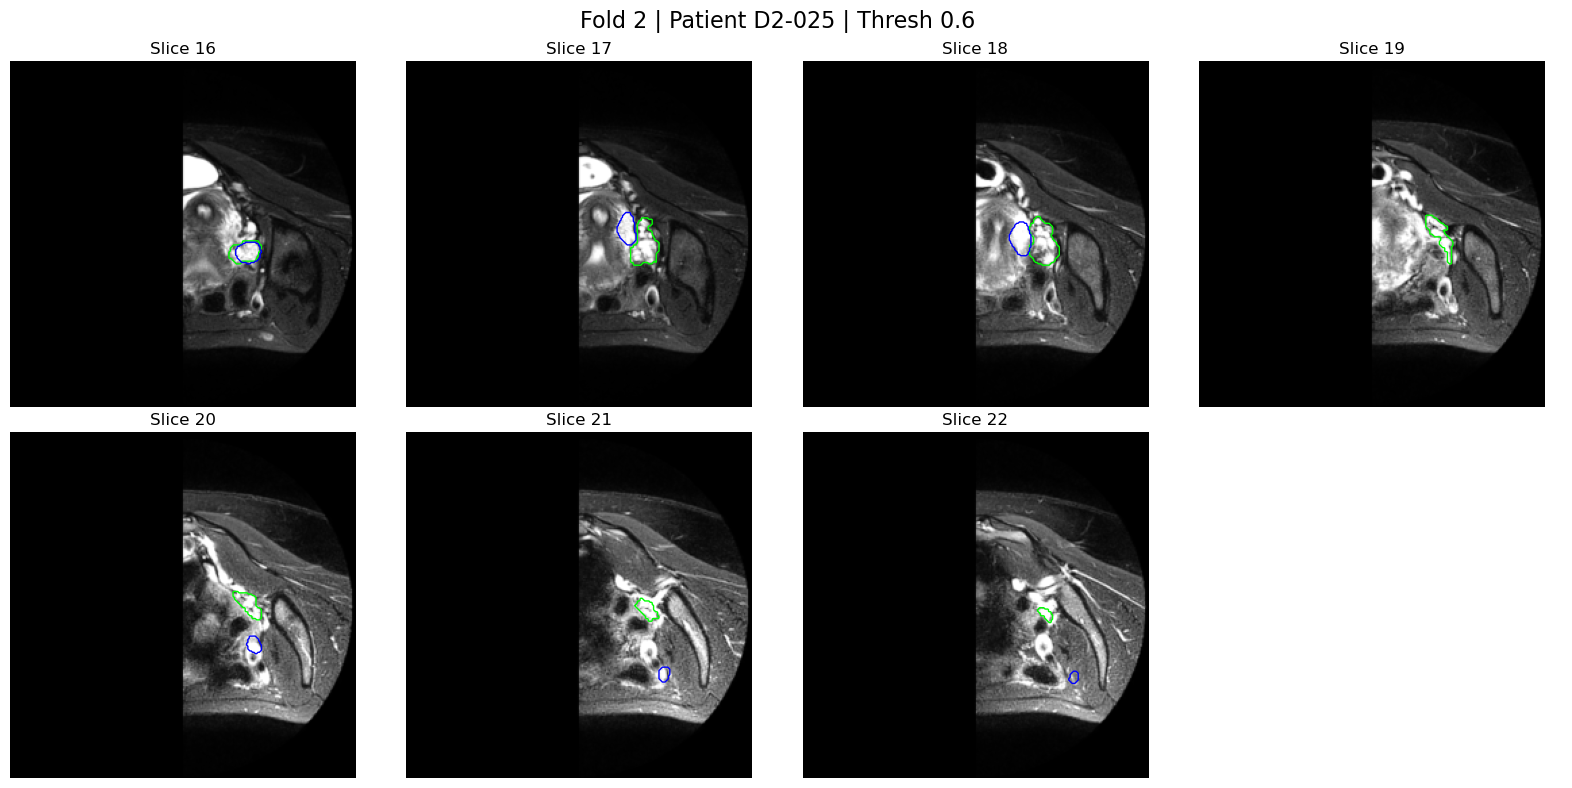



==================== VISUALIZING FOLD 3 (Thresh: 0.3) ====================
Test Patients in this fold: ['D2-016' 'D2-029' 'D2-052' 'D2-017' 'D2-007' 'D2-026' 'D2-044']

--- Patient D2-016 ---


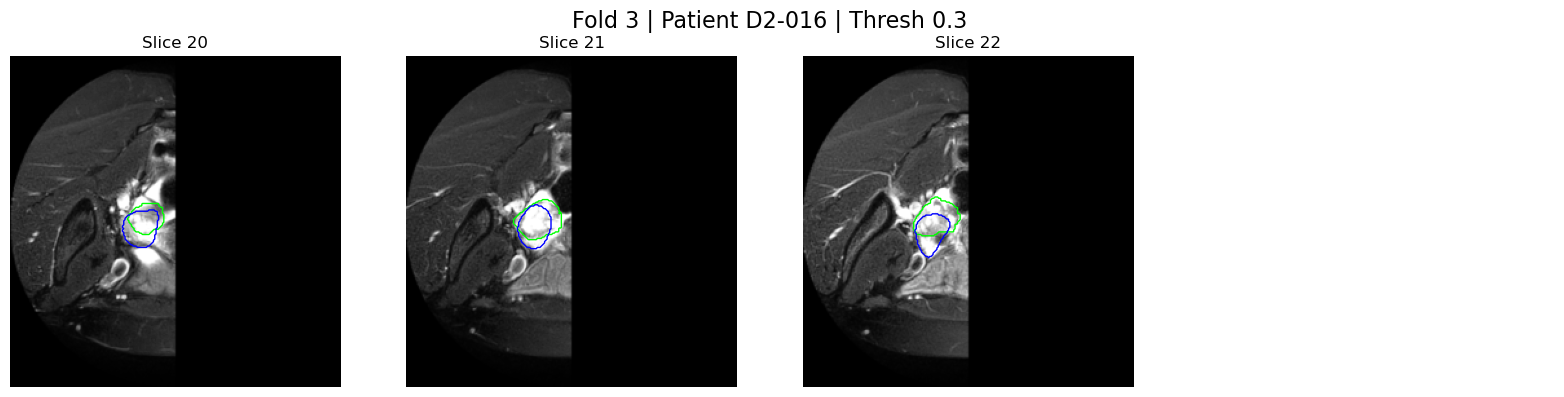


--- Patient D2-029 ---


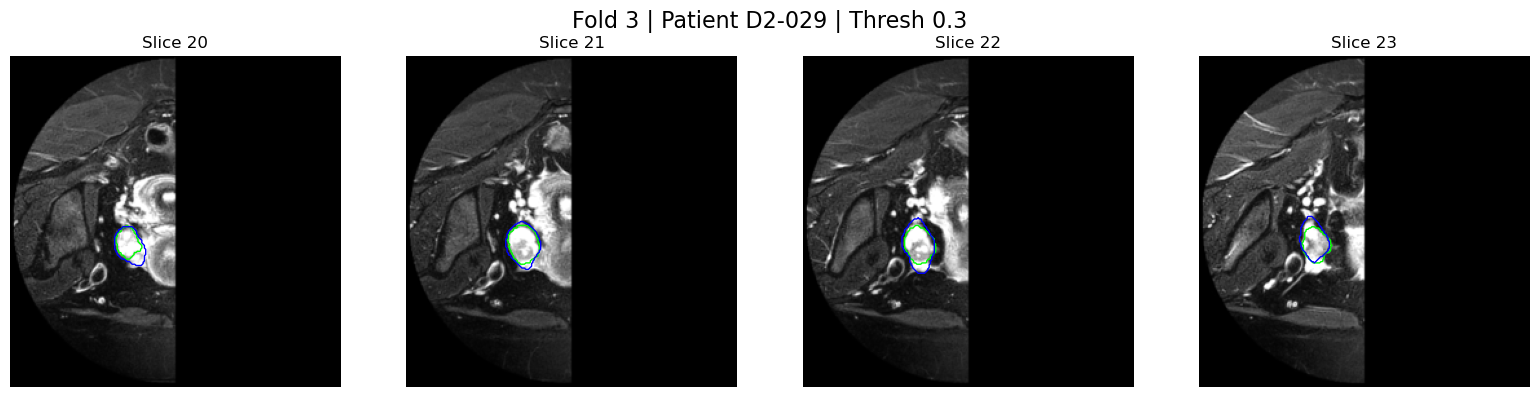


--- Patient D2-052 ---


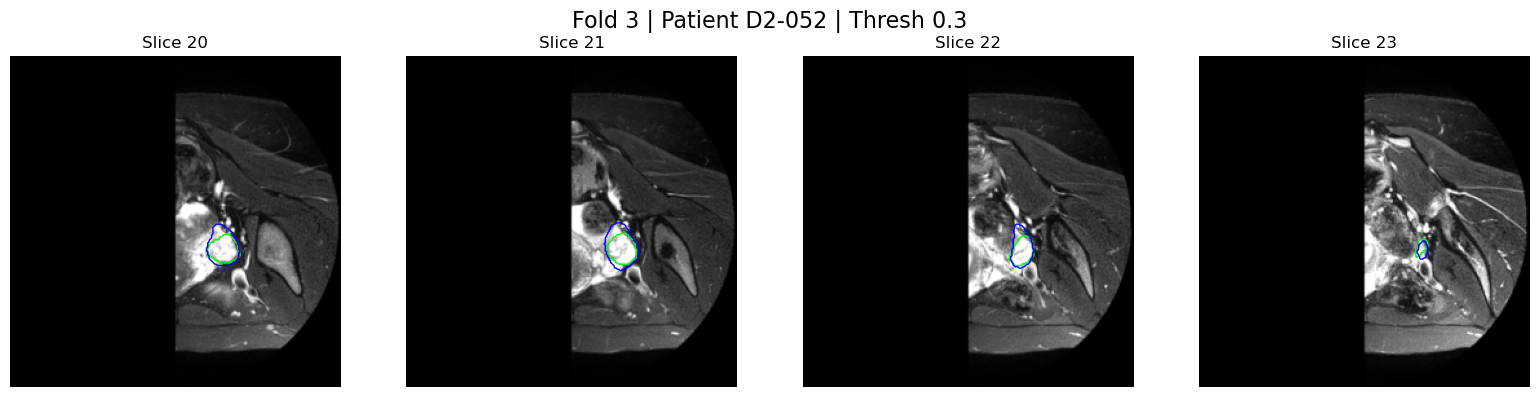


--- Patient D2-017 ---


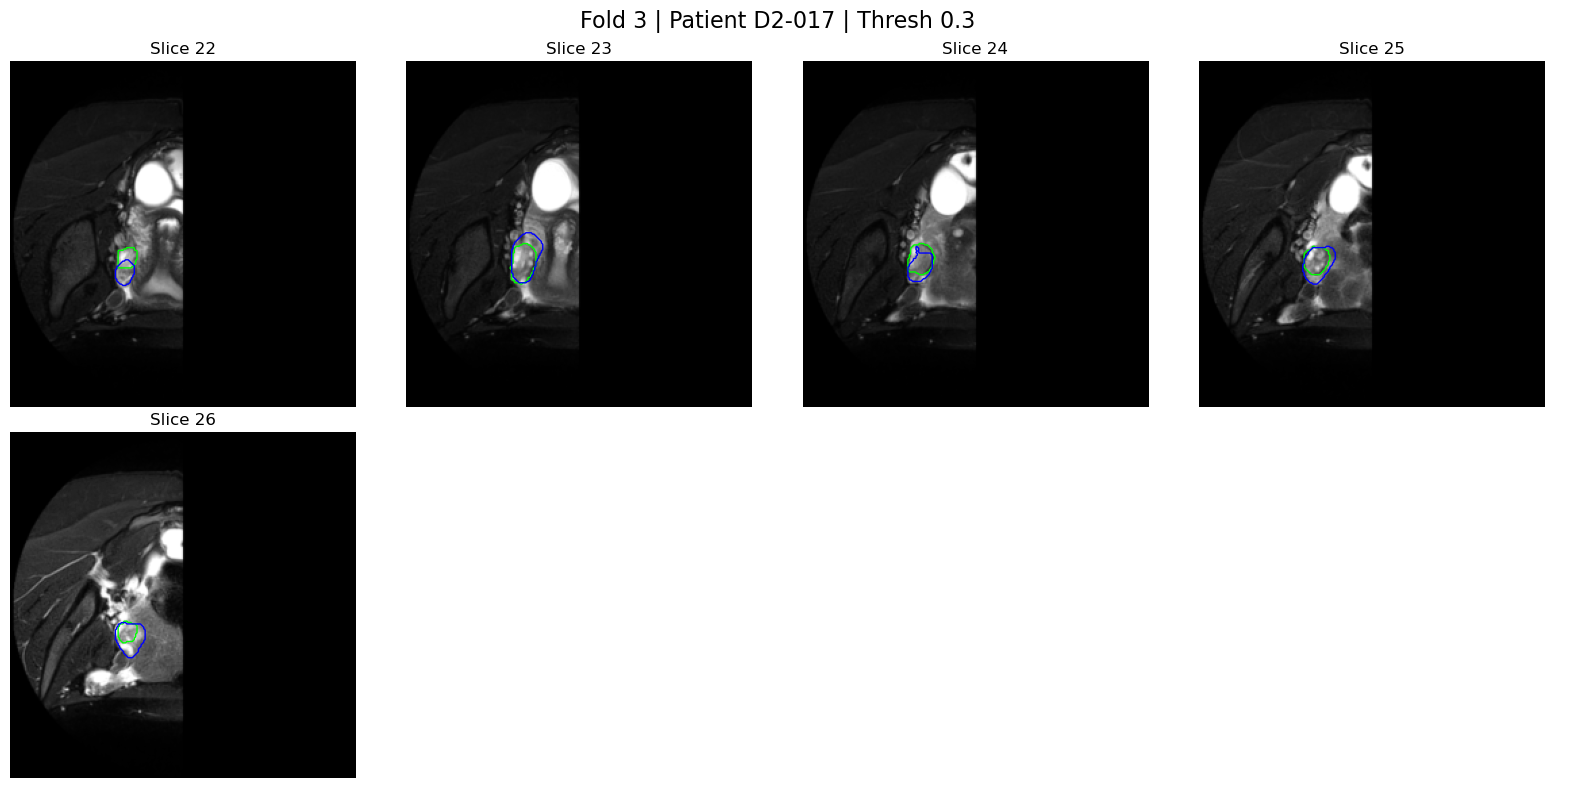


--- Patient D2-007 ---


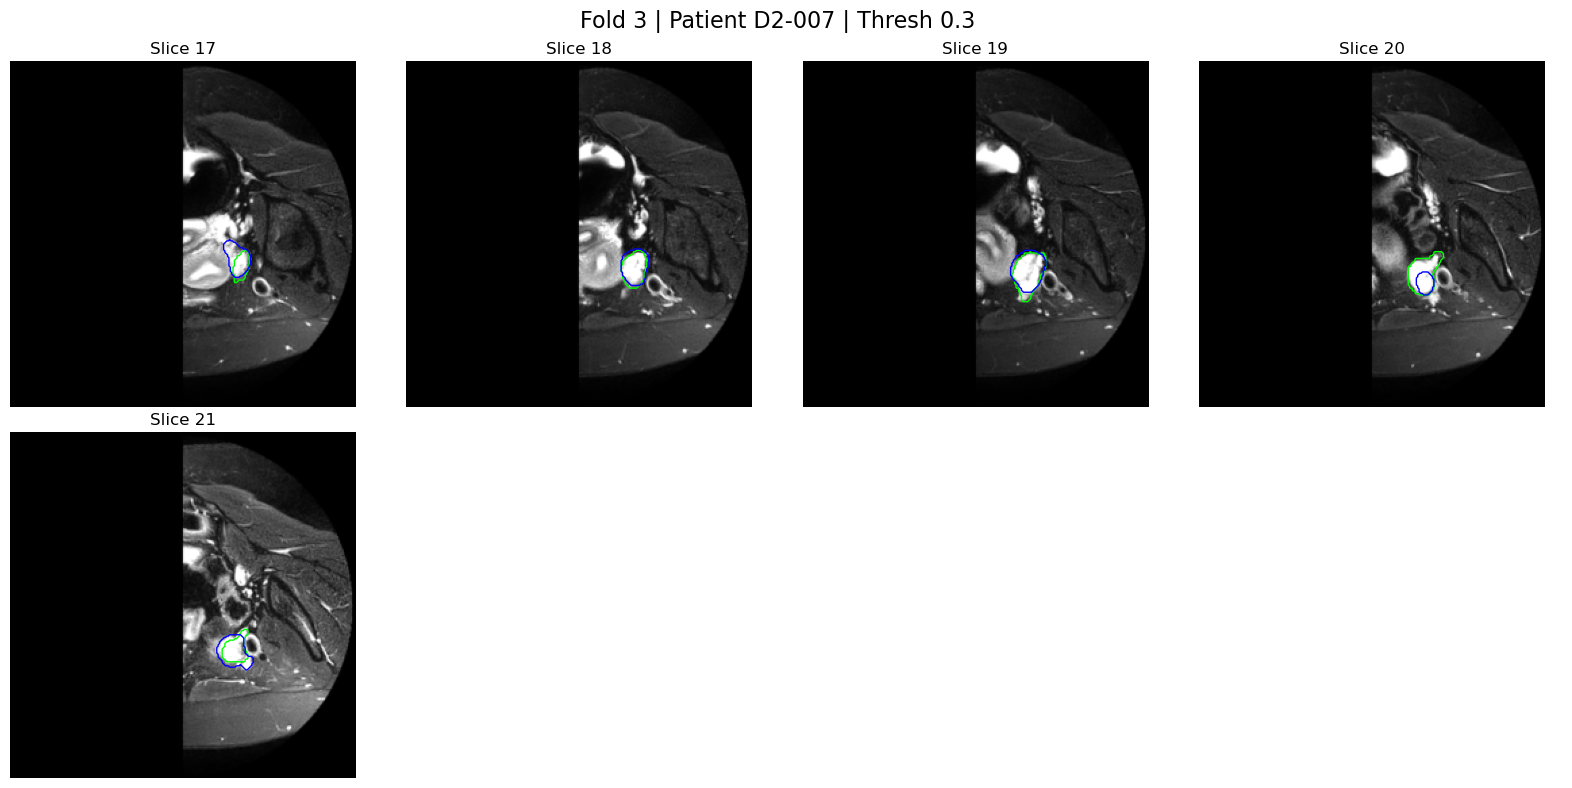


--- Patient D2-026 ---


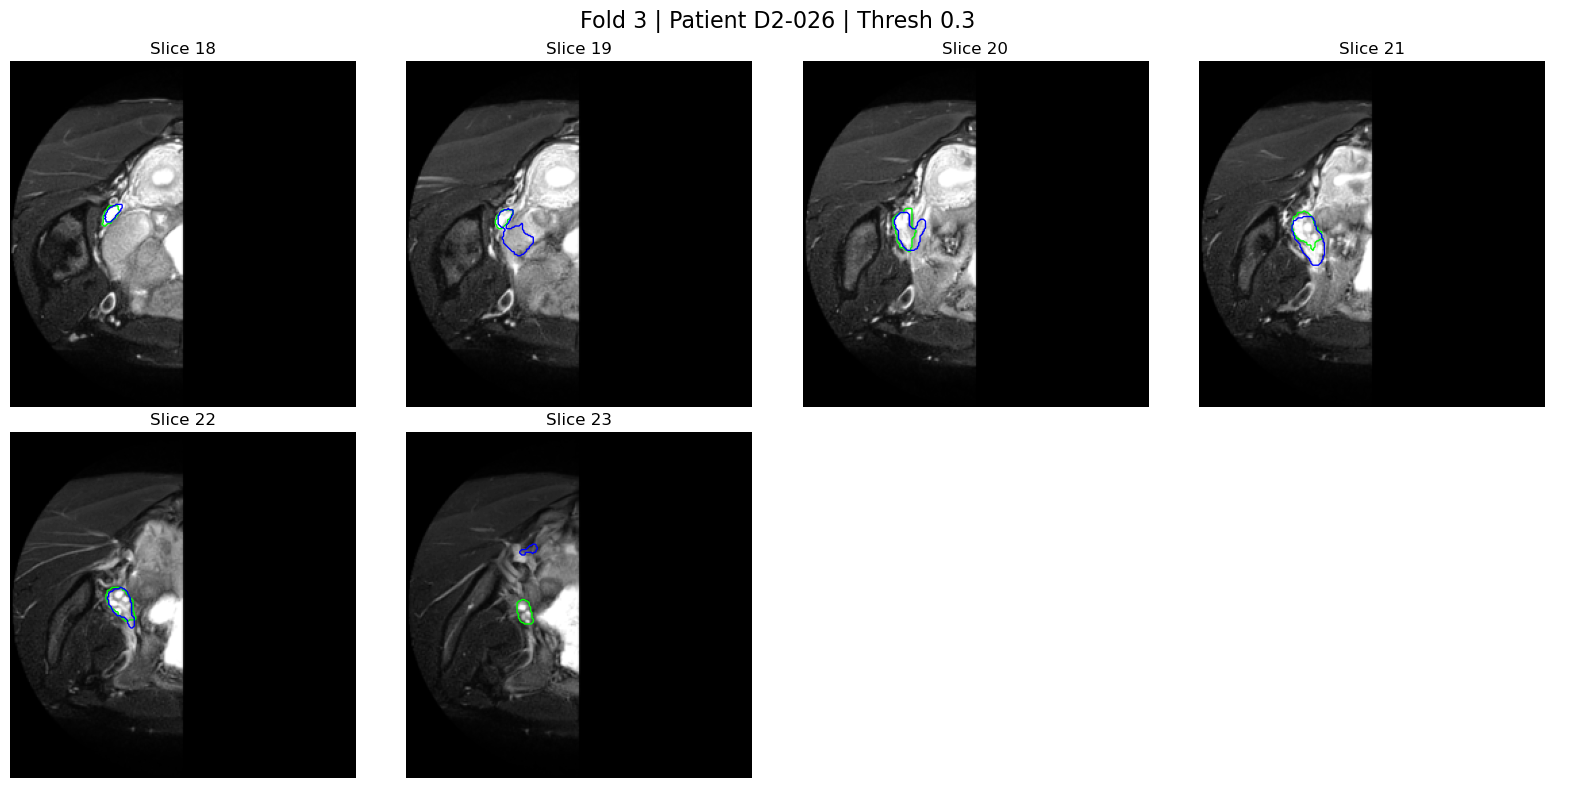


--- Patient D2-044 ---


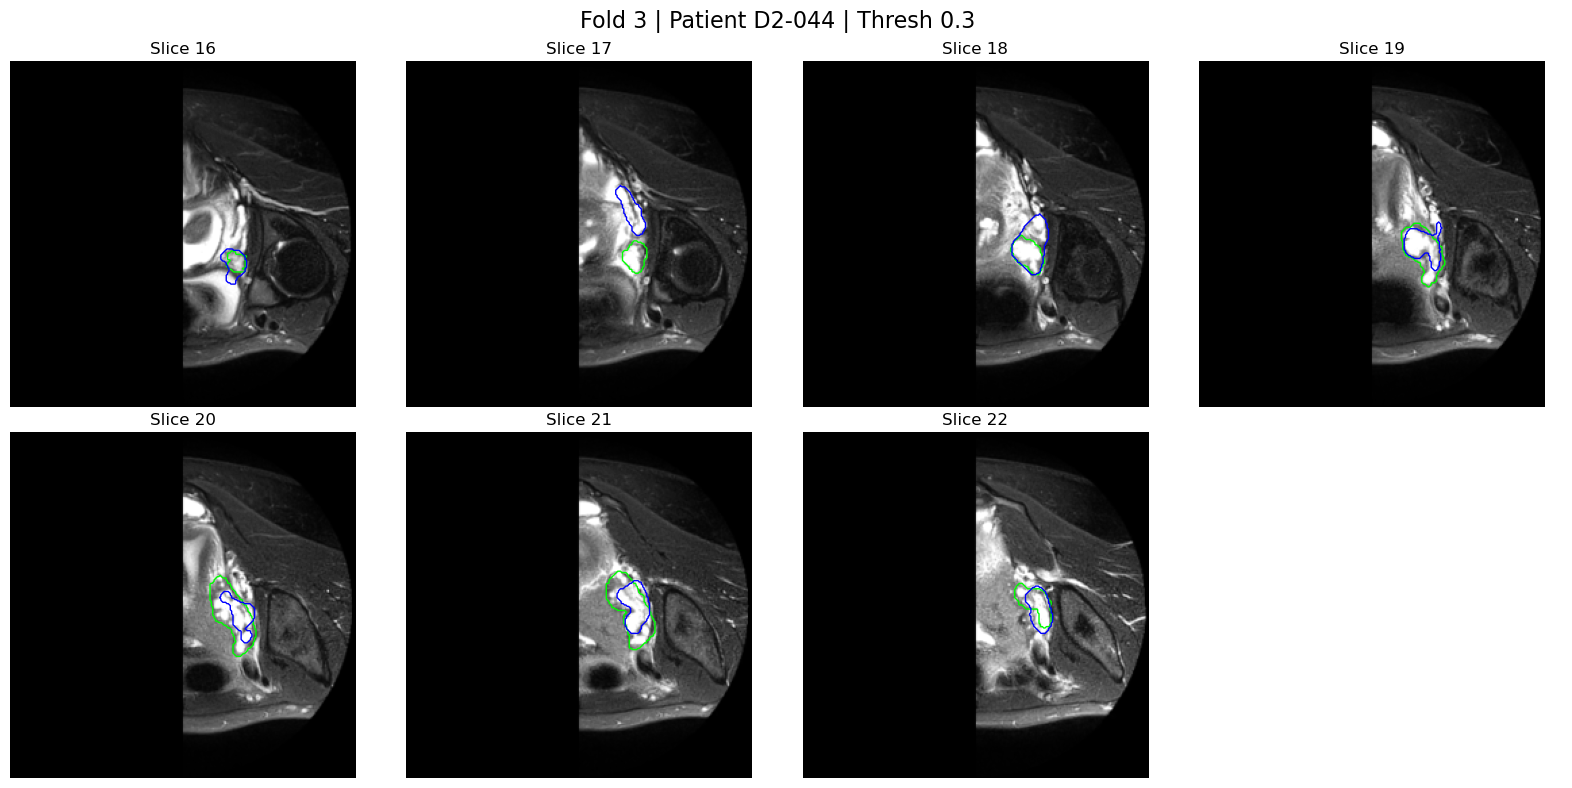

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import nibabel as nib
from pathlib import Path
from skimage import measure
import torch.nn as nn

# --- 1. RE-DEFINE ARCHITECTURE (Must match training exactly) ---
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        return x * self.psi(self.relu(self.W_g(g) + self.W_x(x)))

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(AttentionUNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att4 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        s1 = self.inc(x); s2 = self.down1(s1); s3 = self.down2(s2); s4 = self.down3(s3); s5 = self.down4(s4)
        d4 = self.up1(s5); s4_att = self.att1(g=d4, x=s4); d4 = self.conv1(torch.cat([d4, s4_att], dim=1))
        d3 = self.up2(d4); s3_att = self.att2(g=d3, x=s3); d3 = self.conv2(torch.cat([d3, s3_att], dim=1))
        d2 = self.up3(d3); s2_att = self.att3(g=d2, x=s2); d2 = self.conv3(torch.cat([d2, s2_att], dim=1))
        d1 = self.up4(d2); s1_att = self.att4(g=d1, x=s1); d1 = self.conv4(torch.cat([d1, s1_att], dim=1))
        return self.outc(d1)

# --- 2. CONFIG ---
CONFIG = {
    "data_root": "../data/UT-EndoMRI/D2_Half_Split",
    "manifest_path": "../data/UT-EndoMRI/D2_Half_Split/d2_half_split_manifest.csv",
    "model_dir": "../models/final_5fold_results",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "image_size": 256  # FORCE VISUALIZATION TO THIS SIZE
}

df = pd.read_csv(CONFIG["manifest_path"])

def keep_largest_component(mask):
    labels = measure.label(mask)
    if labels.max() == 0: return mask
    largest_cc = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1
    return largest_cc.astype(np.float32)

def visualize_complete_test_set(fold_idx, threshold):
    print(f"\n\n{'='*20} VISUALIZING FOLD {fold_idx} (Thresh: {threshold}) {'='*20}")
    
    # Load Model
    model_path = Path(CONFIG["model_dir"]) / f"best_model_fold_{fold_idx}.pth"
    if not model_path.exists():
        print(f"Model not found: {model_path}")
        return

    model = AttentionUNet(n_channels=1, n_classes=1).to(CONFIG["device"])
    model.load_state_dict(torch.load(model_path, map_location=CONFIG["device"]))
    model.eval()
    
    # Get Test Patients
    test_patients = df[df['fold'] == fold_idx]['pid'].unique()
    print(f"Test Patients in this fold: {test_patients}")
    
    for pid in test_patients:
        print(f"\n--- Patient {pid} ---")
        row = df[(df['fold'] == fold_idx) & (df['pid'] == pid)].iloc[0]
        
        img_path = Path(CONFIG["data_root"]) / Path(row['t2fs_path']).name
        msk_path = Path(CONFIG["data_root"]) / Path(row['ov_path']).name
        
        img_vol = nib.load(str(img_path)).get_fdata()
        msk_vol = nib.load(str(msk_path)).get_fdata()
        
        # Find ALL positive slices
        z_sums = np.sum(msk_vol, axis=(0,1))
        valid_slices = np.where(z_sums > 0)[0]
        
        if len(valid_slices) == 0:
            print("  No positive slices found in GT.")
            continue
            
        # Plot every positive slice
        n_slices = len(valid_slices)
        cols = 4
        rows = int(np.ceil(n_slices / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        # Handle single slice case
        if rows == 1 and cols == 1: axes = [axes]
        axes = np.array(axes).flatten()
        
        fig.suptitle(f"Fold {fold_idx} | Patient {pid} | Thresh {threshold}", fontsize=16)
        
        for i, z in enumerate(valid_slices):
            ax = axes[i]
            
            # --- PREPROCESSING (Must match training) ---
            img = img_vol[:,:,z]
            msk = msk_vol[:,:,z]
            
            # 1. Norm
            p1, p99 = np.percentile(img, 1), np.percentile(img, 99)
            img_norm = np.clip(img, p1, p99)
            img_norm = (img_norm - img_norm.min()) / (img_norm.max() - img_norm.min() + 1e-8)
            
            # 2. Resize to 256 (This was the missing step in visualization!)
            # We resize the numpy array directly to ensure plotting alignment
            img_t = torch.from_numpy(img_norm.T).float().unsqueeze(0).unsqueeze(0)
            img_t = TF.resize(img_t, [CONFIG["image_size"], CONFIG["image_size"]], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
            
            msk_t = torch.from_numpy(msk.T).float().unsqueeze(0).unsqueeze(0)
            msk_t = TF.resize(msk_t, [CONFIG["image_size"], CONFIG["image_size"]], interpolation=T.InterpolationMode.NEAREST, antialias=True)
            
            # 3. Inference
            img_gpu = img_t.to(CONFIG["device"])
            with torch.no_grad():
                logits = model(img_gpu)
                prob = torch.sigmoid(logits).cpu().numpy().squeeze()
                pred_raw = (prob > threshold).astype(np.float32)
                pred_pp = keep_largest_component(pred_raw)
            
            # 4. Plotting (Now everything is 256x256)
            img_disp = img_t.squeeze().numpy()
            msk_disp = msk_t.squeeze().numpy()
            
            ax.imshow(img_disp, cmap='gray', origin='lower')
            # GT in Green
            if np.sum(msk_disp) > 0:
                ax.contour(msk_disp, colors='lime', linewidths=1, levels=[0.5])
            # Pred in Blue
            if np.sum(pred_pp) > 0:
                ax.contour(pred_pp, colors='blue', linewidths=1, levels=[0.5])
            # Raw Pred in Red (optional, faint)
            # if np.sum(pred_raw) > 0:
            #     ax.contour(pred_raw, colors='red', linewidths=0.5, alpha=0.5, levels=[0.5])
                
            ax.set_title(f"Slice {z}")
            ax.axis('off')
            
        # Turn off unused axes
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()

# --- EXECUTE ---
# Run for the folds we care about
# Fold 0 (Thresh 0.7)
visualize_complete_test_set(0, 0.7)

# Fold 2 (Thresh 0.6) - The "Worst" one
visualize_complete_test_set(2, 0.6)

# Fold 3 (Thresh 0.3) - The "Best" one
visualize_complete_test_set(3, 0.3)

### Final Report Strategy
You are now ready to write. Here is the structure based on your data:

1.  **Abstract:** We tackled single-label ambiguity in MRI. Proposed "Half-Split" + Attention U-Net + Post-Processing. Achieved 0.52 Dice (up from 0.25 baseline).
2.  **Introduction:** Ovaries are hard (intensity overlap). Data is limited (N=37).
3.  **Methods:**
    *   **Data:** D2_Half_Split (explain why: to align input with single-label GT).
    *   **Model:** Attention U-Net (to focus on small targets).
    *   **Training:** 5-Fold CV, AdamW, DiceBCE.
    *   **Inference:** Per-fold threshold tuning + "Keep Largest Component."
4.  **Results:**
    *   **Table:** Copy the dataframe output you just got.
    *   **Key Figure:** The plot from Fold 3 vs Fold 2 (Best vs Worst).
    *   **Observation:** "Post-processing was selected in 100% of folds, proving that false-positive noise is the main error source."
5.  **Discussion:**
    *   **Why 0.52?** It's not 0.90, but given the data constraints (N=37) and the difficulty (T2FS intensity), it's a solid result.
    *   **The Fold 3 Anomaly:** Discuss why Fold 3 was so high (0.69). Was the threshold (0.3) the key? Did it capture faint ovaries that 0.5 missed?
    *   **Future Work:** 3D U-Net (instead of 2D slices) to use z-axis context.